In [264]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick as yb
import shap
import lime

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score as ari
from sklearn.cluster import KMeans

import sklearn.metrics as sm 
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
folder_path = "E:\\Formation Data Scientist\\Projet_5\\ressources\\archive\\"
customers = pd.read_csv(folder_path + "olist_customers_dataset.csv")
order_items = pd.read_csv(folder_path + "olist_order_items_dataset.csv")
orders = pd.read_csv(folder_path + "olist_orders_dataset.csv")
geolocation = pd.read_csv(folder_path + 'olist_geolocation_dataset.csv')
order_payments = pd.read_csv(folder_path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(folder_path + 'olist_order_reviews_dataset.csv')
products = pd.read_csv(folder_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(folder_path + 'olist_sellers_dataset.csv')
translation = pd.read_csv(folder_path + 'product_category_name_translation.csv')


In [5]:
print(customers.shape)
print(order_items.shape)
print(orders.shape)
print(geolocation.shape)
print(order_payments.shape)
print(order_reviews.shape)
print(products.shape)
print(sellers.shape)
print(translation.shape)

(99441, 5)
(112650, 7)
(99441, 8)
(1000163, 5)
(103886, 5)
(99224, 7)
(32951, 9)
(3095, 4)
(71, 2)


In [6]:
orders.order_id.value_counts()

e481f51cbdc54678b7cc49136f2d6af7    1
f01059d0d674e1282df4e8fbbe015aa2    1
fbc17f0f2a2125054d5ac5c22d2d5120    1
9373150545066777b1cd2bc20e93cf8e    1
917399e96f92268dfa2c0351b1b75fba    1
                                   ..
6b8986012d61963295ffa3ea869aff86    1
be879f757debd3b384b540daa6ddd97e    1
ac3ce7eda1246f39509a505242fcc169    1
e801a93b3904ca9e8350f176a037047b    1
66dea50a8b16d9b4dee7af250b4be1a5    1
Name: order_id, Length: 99441, dtype: int64

In [7]:
order_payments.head(1)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33


In [8]:
agg_payment = order_payments.groupby(['order_id','payment_type'])\
                            .agg(payment_value = ('payment_value', 'sum'),
                               payment_sequential = ('payment_sequential', 'max'),
                               #payment_type = ('payment_type', pd.Series.mode)
                               )
agg_payment = agg_payment.reset_index(level=['order_id','payment_type'])                          

In [9]:
agg_payment.head(1)

,order_id,payment_type,payment_value,payment_sequential
0,00010242fe8c5a6d1ba2dd792cb16214,credit_card,72.19,1


In [10]:
order_items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


In [241]:
agg_items = order_items.groupby(['order_id','product_id','seller_id'])\
                              .agg(price = ('price', 'sum'),
                               num_of_item = ('order_item_id', 'max'),
                               #product_id = ('product_id', pd.Series.mode)
                               )
agg_items = agg_items.reset_index(level=['order_id','product_id','seller_id']) 
#agg_items = agg_items['product_id'].apply(lambda x: str(x))

In [242]:
agg_items.head(1)

,order_id,product_id,seller_id,price,num_of_item
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,1


In [14]:
order_reviews.head(1)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59


In [170]:
agg_review = order_reviews.groupby(['order_id','review_id','review_comment_title','review_comment_message'])\
                          .agg(#review_id = ('review_id', 'count'),
                               review_score = ('review_score', 'mean'),
                               #review_title = ('review_comment_title', pd.Series.mode),
                               #review_comment_message = ('review_comment_message', pd.Series.mode),
                               )
agg_review = agg_review.reset_index(level=['order_id','review_id','review_comment_title','review_comment_message']) 

In [171]:
agg_review.shape

(9839, 5)

In [177]:
agg_review.head(1)

,order_id,review_id,review_comment_title,review_comment_message,review_score
0,0006ec9db01a64e59a68b2c340bf65a7,6322c405c0f34bf3ad870fd1a6b1fced,Boa,Excelente serviço de compras on line.,5.0


In [175]:
agg_review[agg_review.review_id == '7bc2406110b926393aa56f80a40eba40']

,order_id,review_id,review_comment_title,review_comment_message,review_score


In [18]:
order_reviews.head(1)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59


In [19]:
customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [20]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [21]:
geolocation.head(1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP


- Merge des catégories de produits et leur nom en Anglais

In [22]:
fus_cats = pd.merge(products,translation,indicator=True)

In [23]:
fus_cats.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,_merge
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,both


- Drop des colonnes non essentielles

In [24]:
fus_cats.drop(columns=['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm',
              'product_width_cm','_merge'],inplace=True)

In [25]:
fus_cats.shape

(32328, 3)

In [26]:
fus_cats.isna().sum()

product_id                       0
product_category_name            0
product_category_name_english    0
dtype: int64

- Fusion de la trame des **clients** et de la trame des **commandes**

In [27]:
fus1 = pd.merge(customers,orders, indicator=True)

In [28]:
fus1.shape

(99441, 13)

In [29]:
fus1.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,_merge
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,both


In [30]:
fus1 = fus1.drop(columns='_merge')

- Fusion de la trame des **clients** et **commandes** avec la trame **paiements**

In [31]:
fus2 = pd.merge(fus1,agg_payment, indicator=True)

In [32]:
fus2

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_value,payment_sequential,_merge
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,credit_card,146.87,1,both
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,credit_card,335.48,1,both
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,credit_card,157.73,1,both
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,credit_card,173.30,1,both
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,credit_card,252.25,1,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101681,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00,credit_card,88.78,1,both
101682,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00,credit_card,129.06,1,both
101683,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00,credit_card,56.04,1,both
101684,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00,credit_card,711.07,1,both


In [33]:
fus2['_merge'].value_counts()

both          101686
left_only          0
right_only         0
Name: _merge, dtype: int64

In [34]:
fus2 = fus2.drop(columns='_merge')

In [35]:
fus2.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_type', 'payment_value',
       'payment_sequential'],
      dtype='object')

- Fusion de la trame des **produits** avec celle des **catégories** de produits

In [36]:
fus_cats.columns


Index(['product_id', 'product_category_name', 'product_category_name_english'], dtype='object')

In [37]:
agg_items.columns

Index(['order_id', 'product_id', 'seller_id', 'price', 'num_of_item'], dtype='object')

In [38]:
fus3 = pd.merge(fus_cats,agg_items)

In [39]:
fus4 = pd.merge(fus3,fus2)

In [40]:
fus4.isna().sum()

product_id                          0
product_category_name               0
product_category_name_english       0
order_id                            0
seller_id                           0
price                               0
num_of_item                         0
customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  13
order_delivered_carrier_date     1018
order_delivered_customer_date    2213
order_estimated_delivery_date       0
payment_type                        0
payment_value                       0
payment_sequential                  0
dtype: int64

In [41]:
#fus4.dropna(axis=0,inplace=True)

In [42]:
fus4.head(1)

,product_id,product_category_name,product_category_name_english,order_id,seller_id,price,num_of_item,customer_id,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_value,payment_sequential
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery,e17e4f88e31525f7deef66779844ddce,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,1,f8a3e963a310aa58b60a5b1fed5bceb5,b1a1199364a4a7fe27c4486ab63f550d,13848,...,SP,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,2018-04-25 17:01:00,2018-04-27 16:42:17,2018-05-09 00:00:00,debit_card,18.3,1


In [43]:
sellers.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [44]:
fus4.columns

Index(['product_id', 'product_category_name', 'product_category_name_english',
       'order_id', 'seller_id', 'price', 'num_of_item', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_value', 'payment_sequential'],
      dtype='object')

In [45]:
fus5 = pd.merge(fus4,sellers)

In [46]:
fus5.shape

(103222, 24)

In [47]:
fus5.columns

Index(['product_id', 'product_category_name', 'product_category_name_english',
       'order_id', 'seller_id', 'price', 'num_of_item', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_value', 'payment_sequential',
       'seller_zip_code_prefix', 'seller_city', 'seller_state'],
      dtype='object')

In [48]:
#fus5 = pd.merge(fus4,geolocation,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',indicator=True)

In [49]:
fus5.shape

(103222, 24)

<AxesSubplot:>

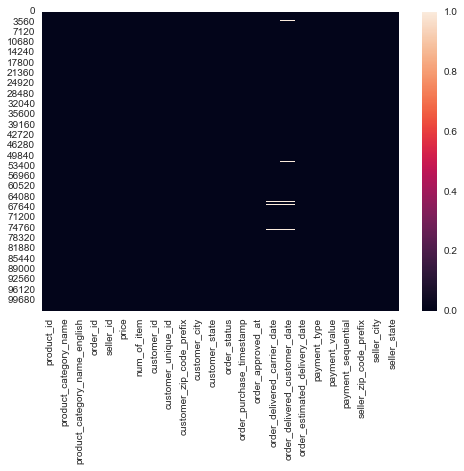

In [50]:
sns.heatmap(fus5.isna())

In [51]:
fus5.isna().sum()

product_id                          0
product_category_name               0
product_category_name_english       0
order_id                            0
seller_id                           0
price                               0
num_of_item                         0
customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  13
order_delivered_carrier_date     1018
order_delivered_customer_date    2213
order_estimated_delivery_date       0
payment_type                        0
payment_value                       0
payment_sequential                  0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
dtype: int64

In [52]:
fus5.duplicated().sum()

0

In [53]:
fus5['customer_unique_id'].value_counts()

8d50f5eadf50201ccdcedfb9e2ac8455    15
3e43e6105506432c953e165fb2acf44c    13
41a3b256cc497dc952a815b848345cbc    12
1b6c7548a2a1f9037c1fd3ddfed95f33    10
ca77025e7201e3b30c44b472ff346268     9
                                    ..
151ab282634af790930a7587fba71ba9     1
2e13c4615dc5f987f5f11007a187359d     1
a9635dae6e36a36a2985b4d083986219     1
85c6ac27accabece375373868f934bc5     1
a6d9bf9bd00ca98f44894adab0578a6f     1
Name: customer_unique_id, Length: 94087, dtype: int64

In [182]:
fus5['payment_value'].describe()

count    103222.000000
mean        160.928878
std         220.943786
min           0.010000
25%          60.740000
50%         104.840000
75%         179.120000
max       13664.080000
Name: payment_value, dtype: float64

In [57]:
#fus5_ = pd.merge(fus5,agg_review)

In [58]:
#fus5_.shape

<a name='C2'> **EDA** </a>

- **Formatage** des dates en DateTime

In [59]:
date = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for i in date:
  fus5[i] = pd.to_datetime(fus5[i],format="%Y-%m-%d %H:%M:%S")
  
fus5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103222 entries, 0 to 103221
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   product_id                     103222 non-null  object        
 1   product_category_name          103222 non-null  object        
 2   product_category_name_english  103222 non-null  object        
 3   order_id                       103222 non-null  object        
 4   seller_id                      103222 non-null  object        
 5   price                          103222 non-null  float64       
 6   num_of_item                    103222 non-null  int64         
 7   customer_id                    103222 non-null  object        
 8   customer_unique_id             103222 non-null  object        
 9   customer_zip_code_prefix       103222 non-null  int64         
 10  customer_city                  103222 non-null  object        
 11  

In [60]:
fus6 = fus5.copy()
fus6['year'] = fus6['order_purchase_timestamp'].dt.year
fus6['month'] = fus6['order_purchase_timestamp'].dt.month
fus6['day'] = fus6['order_purchase_timestamp'].dt.dayofweek
fus6['day_name'] = fus6['order_purchase_timestamp'].dt.day_name()
fus6['month_name'] = fus6['order_purchase_timestamp'].dt.month_name()

In [61]:
fus6.head(1)

,product_id,product_category_name,product_category_name_english,order_id,seller_id,price,num_of_item,customer_id,customer_unique_id,customer_zip_code_prefix,...,payment_value,payment_sequential,seller_zip_code_prefix,seller_city,seller_state,year,month,day,day_name,month_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery,e17e4f88e31525f7deef66779844ddce,5670f4db5b62c43d542e1b2d56b0cf7c,10.91,1,f8a3e963a310aa58b60a5b1fed5bceb5,b1a1199364a4a7fe27c4486ab63f550d,13848,...,18.3,1,3694,sao paulo,SP,2018,4,1,Tuesday,April


In [62]:
fus6['year'].value_counts()

2018    56230
2017    46658
2016      334
Name: year, dtype: int64

In [63]:
fus6['month_name'].unique()

array(['April', 'July', 'June', 'May', 'August', 'November', 'September',
       'October', 'December', 'January', 'February', 'March'],
      dtype=object)

- **Drop** des Null

In [64]:
drop1 = fus6.copy()
""" drop1 = drop1.dropna(axis=0)
drop1.shape """

' drop1 = drop1.dropna(axis=0)\ndrop1.shape '

In [65]:
drop1.columns

Index(['product_id', 'product_category_name', 'product_category_name_english',
       'order_id', 'seller_id', 'price', 'num_of_item', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_value', 'payment_sequential',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'year',
       'month', 'day', 'day_name', 'month_name'],
      dtype='object')

Nous avons besoin des colonnes qui nous donnent des informations sur la **récense**, la **fréquence** et le **montant** des transactions

Drop des features non essentiels

In [66]:
drop1.shape

(103222, 29)

In [67]:
drop1.describe()

,price,num_of_item,customer_zip_code_prefix,payment_value,payment_sequential,seller_zip_code_prefix,year,month,day
count,103222.000000,103222.000000,103222.000000,103222.000000,103222.000000,103222.000000,103222.000000,103222.000000,103222.000000
mean,132.584325,1.150162,35112.601006,160.928878,1.044458,24630.503701,2017.541512,6.039139,2.758249
std,204.730727,0.561610,29772.484300,220.943786,0.378824,27683.015021,0.504728,3.224788,1.967089
min,0.850000,1.000000,1003.000000,0.010000,1.000000,1001.000000,2016.000000,1.000000,0.000000
25%,44.900000,1.000000,11365.000000,60.740000,1.000000,6429.000000,2017.000000,3.000000,1.000000
50%,80.000000,1.000000,24430.000000,104.840000,1.000000,13690.000000,2018.000000,6.000000,3.000000
75%,147.000000,1.000000,58701.000000,179.120000,1.000000,29156.000000,2018.000000,8.000000,4.000000
max,13440.000000,21.000000,99980.000000,13664.080000,29.000000,99730.000000,2018.000000,12.000000,6.000000


In [68]:
drop1.dtypes

product_id                               object
product_category_name                    object
product_category_name_english            object
order_id                                 object
seller_id                                object
price                                   float64
num_of_item                               int64
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
payment_type                             object
payment_value                           float64
payment_sequential                      

<AxesSubplot:>

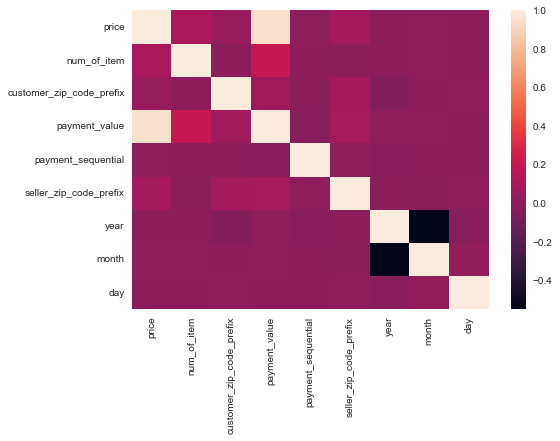

In [69]:
sns.heatmap(drop1.corr())

- Etude des clients par zone géographique

In [70]:
# Trouvons les états avec le plus de clients

customers_state = drop1.groupby(['customer_state']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
customers_state.rename(columns = {'customer_unique_id':'total'}, inplace=True)
customers_state['percentage'] = 100*(customers_state['total']/customers_state['total'].sum())
customers_state

,customer_state,total,percentage
25,SP,43347,41.993955
18,RJ,13338,12.921664
10,MG,12090,11.712619
22,RS,5673,5.495921
17,PR,5209,5.046405
23,SC,3756,3.638759
4,BA,3540,3.429501
6,DF,2226,2.156517
7,ES,2130,2.063514
8,GO,2083,2.017981


Sao Paulo est de loin l'état avec le plus de clients

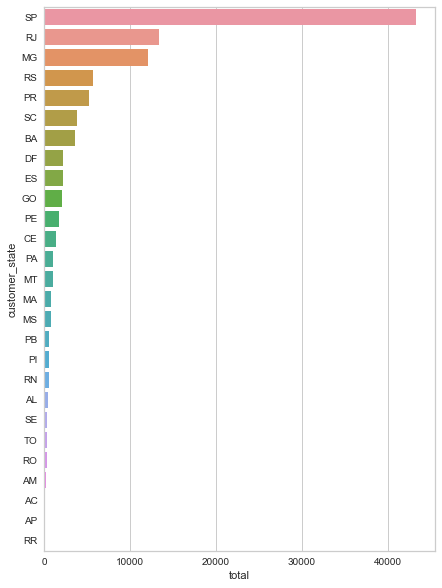

In [71]:
plt.figure(figsize=(7,10))
sns.barplot(data=customers_state,x='total',y='customer_state')
plt.show()

- Etude des clients par catégories de produits acheté

In [110]:
items_cat = drop1.groupby(['product_category_name_english']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
items_cat.rename(columns = {'customer_unique_id':'total'}, inplace=True)
items_cat['percentage'] = 100*(items_cat['total']/items_cat['total'].sum())
items_cat

,product_category_name_english,total,percentage
7,bed_bath_table,10437,10.111217
43,health_beauty,9159,8.873108
65,sports_leisure,8023,7.772568
15,computers_accessories,7025,6.805720
39,furniture_decor,6950,6.733061
...,...,...,...
3,arts_and_craftmanship,24,0.023251
52,la_cuisine,15,0.014532
11,cds_dvds_musicals,12,0.011625
29,fashion_childrens_clothes,8,0.007750


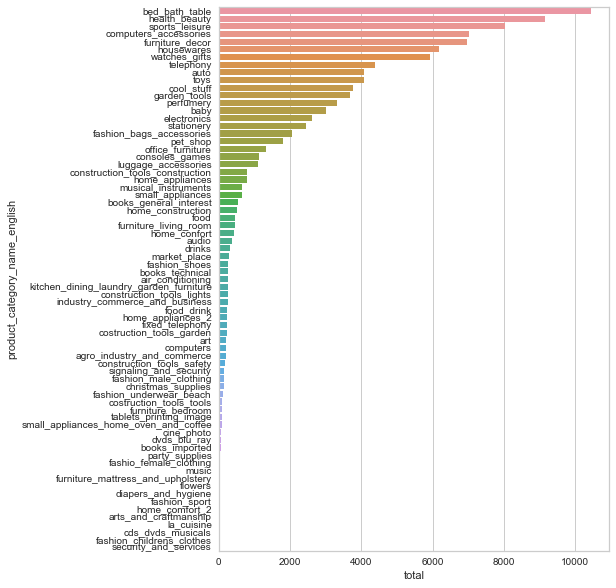

In [111]:
plt.figure(figsize=(7,10))
sns.barplot(data=items_cat,x='total',y='product_category_name_english')
plt.show()

- Etude achats par date

In [112]:
purchase_year = drop1.groupby(['year']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_year.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_year['percentage'] = 100*(purchase_year['total']/purchase_year['total'].sum())
purchase_year

,year,total,percentage
2,2018,56230,54.474821
1,2017,46658,45.201604
0,2016,334,0.323574


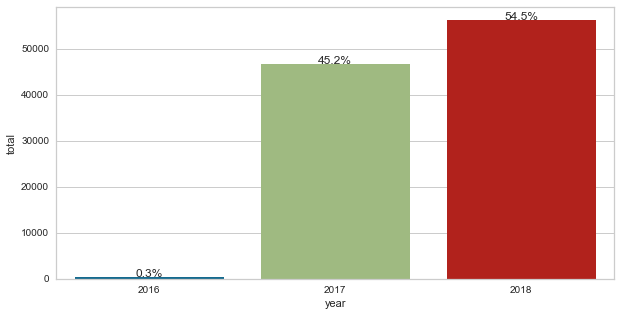

In [113]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_year,x='year',y='total')
total = purchase_year['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [114]:
# the number of order per month
purchase_monthly = drop1[['order_approved_at']].groupby(drop1['order_approved_at'].dt.to_period('M')).agg({'order_approved_at':'count'})
purchase_monthly = purchase_monthly.rename(columns = {'order_approved_at': 'total'})
purchase_monthly = purchase_monthly.reset_index()

purchase_monthly['month_year'] = purchase_monthly['order_approved_at'].dt.strftime('%b-%Y')
purchase_monthly.head()

,order_approved_at,total,month_year
0,2016-10,333,Oct-2016
1,2016-12,1,Dec-2016
2,2017-01,793,Jan-2017
3,2017-02,1777,Feb-2017
4,2017-03,2752,Mar-2017


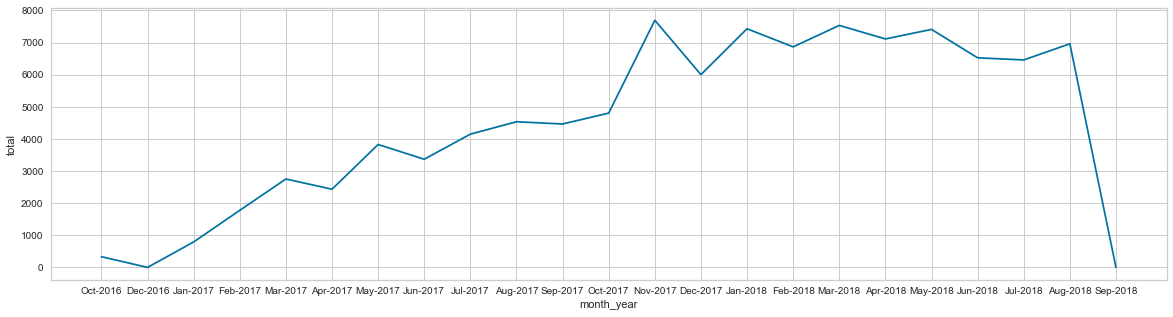

In [115]:
plt.figure(figsize=(20,5))
sns.lineplot(data=purchase_monthly,x='month_year',y='total')
plt.show()

Le plus grand nombre de commandes a été passé en Novembre 2017

In [116]:
order_monthly = drop1[['order_approved_at']].groupby(drop1['order_approved_at'].dt.month.sort_index()).count()
order_monthly

,order_approved_at
order_approved_at,
1.0,8221
2.0,8641
3.0,10284
4.0,9545
5.0,11234
6.0,9891
7.0,10605
8.0,11495
9.0,4465


In [117]:
month_index = order_monthly.rename(columns = {'order_approved_at': 'total_orders'})
monthly_trend = month_index.reset_index()

# rechange in to day in a week
moy = ['January','February','March','April','May','June','July','August','September','October','November','December']
for i in range(12):
  monthly_trend['order_approved_at'] = monthly_trend['order_approved_at'].replace(i,moy[i])
monthly_trend

,order_approved_at,total_orders
0,February,8221
1,March,8641
2,April,10284
3,May,9545
4,June,11234
5,July,9891
6,August,10605
7,September,11495
8,October,4465
9,November,5136


In [118]:
purchase_month = drop1.groupby(['month_name']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_month.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_month['percentage'] = 100*(purchase_month['total'] / purchase_month['total'].sum())
purchase_month

,month_name,total,percentage
1,August,11301,10.948247
8,May,11022,10.677956
5,July,10769,10.432853
7,March,10199,9.880646
6,June,9887,9.578384
0,April,9746,9.441786
3,February,8670,8.399372
4,January,8344,8.083548
9,November,7838,7.593343
2,December,5827,5.645114


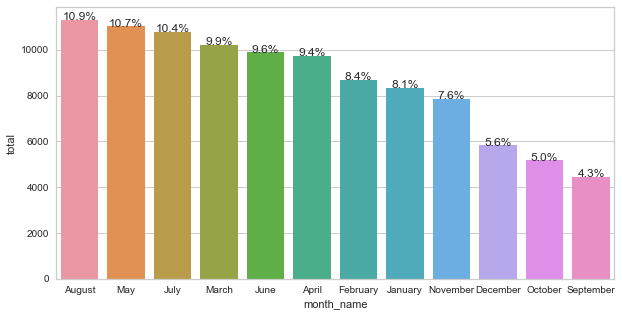

In [119]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_month,x='month_name',y='total')
total = purchase_month['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [120]:
purchase_day = drop1.groupby(['day_name']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_day.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_day

,day_name,total
1,Monday,16792
5,Tuesday,16592
6,Wednesday,16054
4,Thursday,15311
0,Friday,14714
3,Sunday,12428
2,Saturday,11331


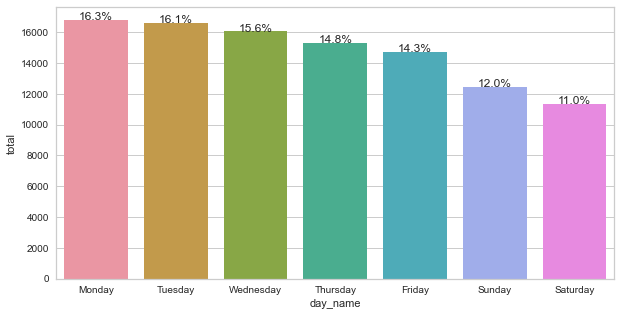

In [121]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_day,x='day_name',y='total')
total = purchase_day['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [122]:
payment_type = drop1.groupby(['payment_type']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
payment_type.rename(columns = {'customer_unique_id':'total'}, inplace=True)
payment_type['percentage'] = 100*(payment_type['total'] / payment_type['total'].sum())
payment_type

,payment_type,total,percentage
1,credit_card,77832,75.402530
0,boleto,20002,19.377652
3,voucher,3835,3.715293
2,debit_card,1553,1.504524


Le moyen de paiement le plus populaire est la carte de crédit ensuite boleto

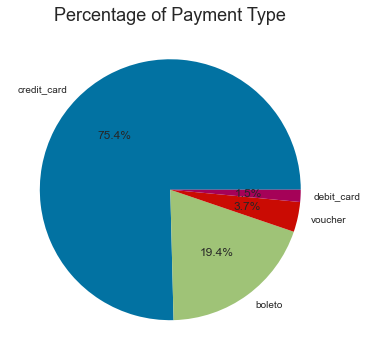

In [123]:
label = payment_type['payment_type']
plt.figure(figsize=(6,6))
plt.title('Percentage of Payment Type', fontsize = 18)
plt.pie(payment_type['total'], labels = label,autopct = '%0.1f%%')
plt.show()

<a name='C2'> - Classement par clients et commandes </a>

Calcul du nombre de clients ayant passé plus d'une commande

Paiement moyen par clients

In [186]:
mean_payment = drop1[['customer_unique_id','payment_value']].groupby(by=['customer_unique_id'],dropna=False).mean().reset_index()
count_payment = drop1[['customer_unique_id','payment_value']].groupby(by=['customer_unique_id'],dropna=False).count().reset_index()
result = pd.merge(mean_payment, count_payment, how="inner", on='customer_unique_id',suffixes=('_avg', '_count'))
result.sort_values('payment_value_avg',ascending=False).reset_index(drop=True)

,customer_unique_id,payment_value_avg,payment_value_count
0,0a0a92112bd4c708ca5fde585afaa872,13664.080,1
1,763c8b1c9c68a0229c42c9fc6f662b93,7274.880,1
2,dc4802a71eae9be1dd28f5d788ceb526,6929.310,1
3,459bef486812aa25204be022145caa62,6922.210,1
4,ff4159b92c40ebe40454e3e6a7c35ed6,6726.660,1
...,...,...,...
94082,c7ca47747878996a42d992f15dcf023c,9.180,2
94083,1e007f34a068548c0f0a411e301fa115,8.690,2
94084,f55b7e6959225119961d9cf0d867d970,8.025,2
94085,9d8df7449e1d21fe9a849673a8648b83,7.590,2


Text(0, 0.5, 'Frequency')

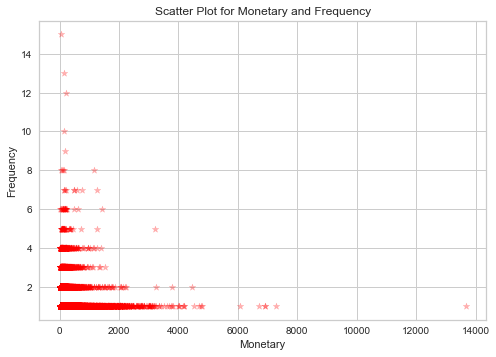

In [126]:
plt.scatter(result['payment_value_avg'], result['payment_value_count'],
            color = 'red',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Monetary and Frequency')
plt.xlabel('Monetary')
plt.ylabel('Frequency')

In [189]:
customers_grp = drop1.groupby(['customer_unique_id','order_approved_at']).sum()
customers_grp

,,price,num_of_item,customer_zip_code_prefix,payment_value,payment_sequential,seller_zip_code_prefix,year,month,day
customer_unique_id,order_approved_at,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,129.90,1,7787,141.90,1,13405,2018,5,3
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,18.90,1,6053,27.19,1,2215,2018,5,0
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,69.00,1,88115,86.22,1,13232,2017,3,4
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,25.99,1,66812,43.62,1,3569,2017,10,3
0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,180.00,1,18040,196.89,1,12327,2017,11,1
...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:15:16,1570.00,3,110500,4134.84,2,7816,4034,12,6
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20,64.89,1,44054,84.58,1,18500,2017,12,6
ffff371b4d645b6ecea244b27531430a,2017-02-07 16:02:44,89.90,1,78552,112.46,1,30550,2017,2,1


In [128]:
sorted_customers_grp = customers_grp['payment_value'].value_counts().sort_values(ascending=False)
sorted_customers_grp

77.57      252
35.00      166
73.34      161
116.94     131
56.78      123
          ... 
359.04       1
659.15       1
309.51       1
35.83        1
4134.84      1
Name: payment_value, Length: 28552, dtype: int64

In [129]:
drop1.columns

Index(['product_id', 'product_category_name', 'product_category_name_english',
       'order_id', 'seller_id', 'price', 'num_of_item', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_value', 'payment_sequential',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'year',
       'month', 'day', 'day_name', 'month_name'],
      dtype='object')

In [234]:
_clients_num_orders = drop1.groupby(['customer_unique_id','order_approved_at','payment_value'])['num_of_item'].count().reset_index()
_clients_num_orders



,customer_unique_id,order_approved_at,payment_value,num_of_item
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,27.19,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,196.89,1
...,...,...,...,...
99418,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:15:16,2067.42,2
99419,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20,84.58,1
99420,ffff371b4d645b6ecea244b27531430a,2017-02-07 16:02:44,112.46,1
99421,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:58:47,133.69,1


75% des clients ont donnée une note de 5 et 4

In [236]:
sum(_clients_num_orders.num_of_item > 1)


3263

In [245]:
_clients_num_orders.sort_values(by='num_of_item',ascending=False)

,customer_unique_id,order_approved_at,payment_value,num_of_item
78170,c8ed31310fc440a3f8031b177f9842c3,2018-08-12 02:25:07,1157.28,8
34786,595e38fad1949e25468ad1c7c06924d0,2018-05-12 22:50:11,582.94,7
20183,33de26d1fafbfd4945eb586f7136efe6,2017-11-23 02:36:26,1242.57,7
74530,bf869f6a89c8ba217f47e22359f884f2,2018-08-16 04:44:00,209.57,7
25494,41a3b256cc497dc952a815b848345cbc,2018-01-29 11:35:23,400.00,6
...,...,...,...,...
33660,56aa2869985453b8c205ee9ef0a1f2c0,2018-08-04 17:45:13,200.33,1
33659,56a9c159fffe93bdef88ffbf6e729712,2017-05-13 16:55:13,128.31,1
33658,56a92d4ae6da383232787ec2b840a711,2018-05-09 19:34:06,568.63,1
33657,56a5ac6efdc86f167b16c26fe1b4c91f,2017-10-24 10:56:15,237.47,1


Seul 3.28% des clients ont passé plus d'une commande

In [135]:
df_ = drop1[['customer_unique_id','order_approved_at','payment_value']].copy()
df_.head()

,customer_unique_id,order_approved_at,payment_value
0,b1a1199364a4a7fe27c4486ab63f550d,2018-04-24 19:04:19,18.30
1,fc68ba9c34778e17224154c255b5656e,2018-07-05 16:33:14,289.45
2,c67329fd07872a68d6d6d1f1626a0760,2018-04-24 19:17:45,57.75
3,1b6d2664b20a04a1fa9c900aedf29440,2018-07-30 18:31:13,286.45
4,ac13a41fc49bcb3bdcd86142b8ffc0f0,2018-06-18 21:58:24,24.27


In [228]:
df_clients = df_.groupby('customer_unique_id').agg(number=('order_approved_at','count'),
                                                   total=('payment_value','sum')).reset_index()
df_clients

,customer_unique_id,number,total
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19
2,0000f46a3911fa3c0805444483337064,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,196.89
...,...,...,...
94082,fffcf5a5ff07b0908bd4e2dbc735a684,2,4134.84
94083,fffea47cd6d3cc0a88bd621562a9d061,1,84.58
94084,ffff371b4d645b6ecea244b27531430a,1,112.46
94085,ffff5962728ec6157033ef9805bacc48,1,133.69


In [229]:
df_clients[df_clients.number > 1]

,customer_unique_id,number,total
7,00053a61a98854899e70ed204dd4bafe,2,838.36
18,000de6019bb59f34c099a907c151d855,2,514.88
19,000e309254ab1fc5ba99dd469d36bdb4,2,78.42
22,000fbf0473c10fc1ab6f8d2d286ce20c,2,724.76
35,001926cef41060fae572e2e7b30bd2a4,2,182.42
...,...,...,...
94029,ffd6f65402f2bc47238ecd2bdc93e0d4,2,166.92
94042,ffe254cc039740e17dd15a5305035928,2,80.12
94064,ffeddf8aa7cdecf403e77b2e9a99e2ea,2,204.20
94077,fff7219c86179ca6441b8f37823ba3d3,2,531.60


In [136]:
df_clients = df_.groupby('customer_unique_id')[['order_approved_at','payment_value']].mean()
df_clients

,payment_value
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
0000f46a3911fa3c0805444483337064,86.22
0000f6ccb0745a6a4b88665a16c9f078,43.62
0004aac84e0df4da2b147fca70cf8255,196.89
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
fffea47cd6d3cc0a88bd621562a9d061,84.58
ffff371b4d645b6ecea244b27531430a,112.46


Calcul de la date de la première commande et celle de la dernière commande

In [137]:
print(f'Min : {min(drop1.order_approved_at)}, Max : {max(drop1.order_approved_at)}')

Min : 2016-10-04 09:43:32, Max : 2018-09-03 17:40:06


Nous allons utiliser la date de la dernière commande + 1 comme date de reference , afin de calculer la récense des commandes

In [138]:
last_date = drop1['order_approved_at'].max() + pd.to_timedelta(1, 'd')
last_date

Timestamp('2018-09-04 17:40:06')

In [202]:
_clients_num_orders.to_frame().reset_index(level=['customer_unique_id','payment_value','order_id','order_approved_at']).head(1)

ValueError: cannot insert order_approved_at, already exists

In [247]:
rfm_ = _clients_num_orders.reset_index()\
          .groupby('customer_unique_id')\
          .agg(Recency = ('order_approved_at', lambda x: (last_date - x.max()).days ),
                 Frequency = ('num_of_item', 'size'),
                 Monetary = ('payment_value', 'sum'),
                 #score = ('review_score','mean')
                 )

In [139]:
rfm = drop1.reset_index()\
          .groupby('customer_unique_id')\
          .agg(Recency = ('order_approved_at', lambda x: (last_date - x.max()).days ),
                 Frequency = ('order_id', 'size'),
                 Monetary = ('payment_value', 'sum'),
                 #score = ('review_score','mean')
                 )

In [254]:
rfm_

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
0000f46a3911fa3c0805444483337064,542,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
0004aac84e0df4da2b147fca70cf8255,293,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,267,1,84.58
ffff371b4d645b6ecea244b27531430a,574,1,112.46


In [255]:
rfm_.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,94075.0,242.946862,153.125240,1.00,119.00,224.00,352.000,700.00
Frequency,94075.0,1.056848,0.263706,1.00,1.00,1.00,1.000,15.00
Monetary,94075.0,166.203962,228.272917,9.59,63.13,107.85,183.835,13664.08


In [256]:
percn = rfm_[rfm_['Frequency'] > 1].value_counts()
percn

Recency  Frequency  Monetary
330      2          72.14       2
225      2          165.30      2
261      2          88.72       2
605      2          38.24       2
202      2          168.06      2
                               ..
155      2          515.32      1
                    470.25      1
                    337.83      1
                    300.47      1
698      2          161.24      1
Length: 4862, dtype: int64

<AxesSubplot:xlabel='Frequency'>

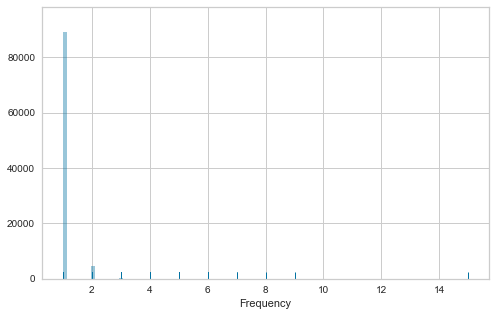

In [257]:
plt.figure(figsize=(8,5))
sns.distplot(rfm_.Frequency,bins=100,kde=False,rug=True)

Text(0, 0.5, 'Frequency')

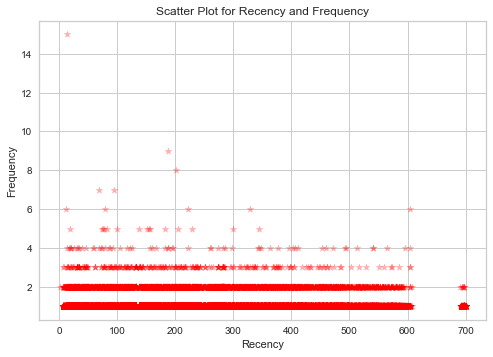

In [259]:
plt.scatter(rfm_.Recency, rfm_.Frequency,
            color = 'red',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Recency and Frequency') 
plt.xlabel('Recency')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

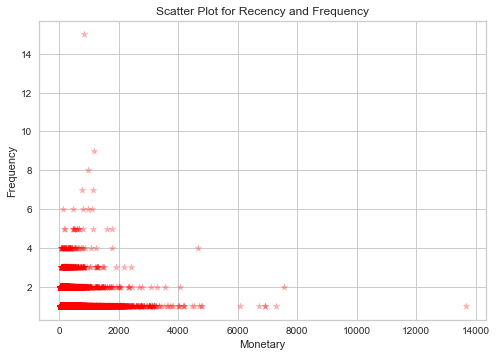

In [263]:
plt.scatter(rfm_.Monetary, rfm_.Frequency,
            color = 'red',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Recency and Frequency') 
plt.xlabel('Monetary')
plt.ylabel('Frequency')

On peut voir que les clients qui achètent le plus souvent dépense moins d'argent.

KMeans Clustering

In [269]:
X = rfm_.values

In [268]:
kmeans = KMeans(n_clusters=10,random_state=0)
kmeans.fit(X)

KMeans(n_clusters=10, random_state=0)

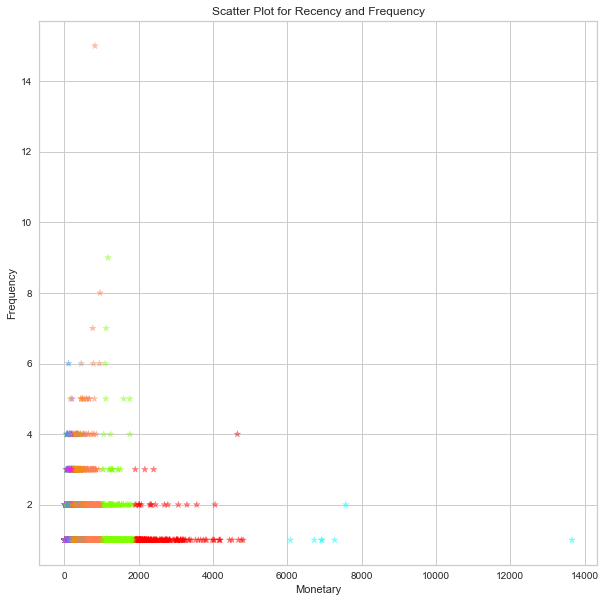

In [281]:
color_theme = np.array(["darkgray",'rosybrown','red','coral','darkorange','yellowgreen','chartreuse','dodgerblue','aqua','fuchsia'])
plt.figure(figsize=(10,10))
plt.scatter(rfm_.Monetary, rfm_.Frequency,
            c = color_theme[kmeans.labels_],
            marker = '*', alpha = 0.5)

plt.title('Scatter Plot for Recency and Frequency') 
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.show()

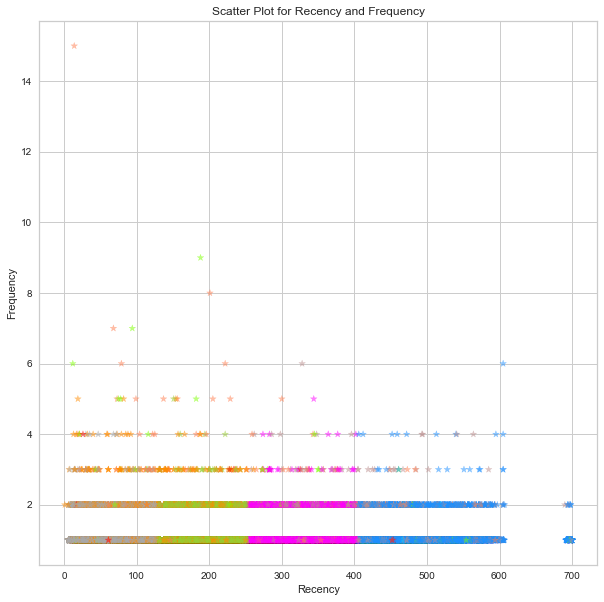

In [283]:
color_theme = np.array(["darkgray",'rosybrown','red','coral','darkorange','yellowgreen','chartreuse','dodgerblue','aqua','fuchsia'])
plt.figure(figsize=(10,10))
plt.scatter(rfm_.Recency, rfm_.Frequency,
            c = color_theme[kmeans.labels_],
            marker = '*', alpha = 0.5)

plt.title('Scatter Plot for Recency and Frequency') 
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()